In [2]:
import pandas as pd
import time
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import os
from matplotlib import pyplot as plt

d:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv('../01-data-collection/hate_speech_longer.csv',index_col=0)
df.sample(n=5)

,label,id,text,hashtag,follower_count,friends_count,retweet_count,favorite_count
3146,none,13857342,@mwlauthor huh?,NaN,19170,797,0,0
2933,none,930620467,"@ThelmaSleaze ...such as crafts (needlepoint, ...",NaN,19819,258,0,0
818,none,13857342,@JWYoder i got spells for that.,NaN,20161,780,0,0
852,none,2942269873,I love this show #MKR,MKR,27,53,0,1
1478,none,365105604,A 7? This bloke is utterly demented. #MKR,MKR,877,380,2,4


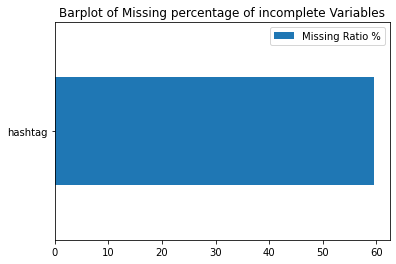

In [4]:
def plot_nas(trainData: pd.DataFrame):
    if trainData.isnull().sum().sum() != 0:
        na_df = (trainData.isnull().sum() / len(trainData)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.title('Barplot of Missing percentage of incomplete Variables')
        plt.show()
    else:
        print('No NAs found')
plot_nas(df)

In [5]:
df.drop(columns=['hashtag'],inplace=True)
df.label.unique()

array(['none', 'sexism', 'racism'], dtype=object)

In [6]:
map = {'none':0,
        'sexism':1,
        'racism':1
        }
df.label = df.label.map(map)

In [7]:
df

,label,id,text,follower_count,friends_count,retweet_count,favorite_count
0,0,13857342,"@GemmaNoon it's what i'm *trying* to do, at le...",20161,780,0,0
1,0,13857342,Just saw this fly by on my stats display a few...,20161,780,0,4
2,1,82522377,"Sauce, capsicum and stock from a packet / jar....",4,64,0,1
3,0,13857342,I think I'm just going to play video games all...,20161,780,1,30
4,0,930620467,@ThelmaSleaze We can fight against systemic pr...,18807,263,0,0
...,...,...,...,...,...,...,...
3528,0,14861476,Beans on toast for dinner tonight. Would score...,415,830,0,1
3529,1,2756873076,Is it lost on most #QuestionsForMen was essent...,1796,1857,1,3
3530,0,13857342,Step 1: post to facebook.\nStep 2: KiA links t...,19172,797,5,5
3531,1,2756873076,RT @fruitondabottom: @MT8_9 Didn't you hear ab...,1796,1857,1,0


In [22]:
a = df[df.text.str.contains('RT')]
a[a.label==1].values[3]

array([1, 1130887939,
       'RT @laurapolot: How can someone fuck up cous cous for fuck sake. I can make that shit with my eyes closed #mkr',
       198, 155, 2, 0], dtype=object)

In [23]:
df.shape

(3533, 7)

In [24]:
#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text
#1.build lemmatize models, and stopwords dictionary
stopwords = stopwords.words('English')
# the pipeline to process the raw text data
def pipeline(text:str):
    lm = WordNetLemmatizer()
    text = text.lower()
    # remove the hashtags and remove all the mentions@
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
    text=re.sub("\\W"," ",text) # remove special chars
    str_input = re.sub(pattern=r'[^a-zA-z]',repl=' ',string=text) #remove words except digit and words
#     str_output = correct_sentence_spelling(sentence = str_input) # it is too time-consuming
    token_list = word_tokenize(str_input)
    token_list = [lm.lemmatize(i) for i in token_list]
    word_list = [word for word in token_list if word not in stopwords]
    word_str = ' '.join(word_list)
    return word_str
def preprocess(text):
    # text = strip_emoji(text)
    text = decontract(text)
    text = pipeline(text)
    return text

In [25]:
texts_cleaned = []
for t in df.text:
    texts_cleaned.append(preprocess(t))
df.loc[:,'texts_cleaned'] = np.array(texts_cleaned)
df.head()

,label,id,text,follower_count,friends_count,retweet_count,favorite_count,texts_cleaned
0,0,13857342,"@GemmaNoon it's what i'm *trying* to do, at le...",20161,780,0,0,trying least targeting specific group cause tr...
1,0,13857342,Just saw this fly by on my stats display a few...,20161,780,0,4,saw fly stats display time tweetstats hashtag ...
2,1,82522377,"Sauce, capsicum and stock from a packet / jar....",4,64,0,1,sauce capsicum stock packet jar quality cookin...
3,0,13857342,I think I'm just going to play video games all...,20161,780,1,30,think going play video game day super stressfu...
4,0,930620467,@ThelmaSleaze We can fight against systemic pr...,18807,263,0,0,fight systemic problem time offering real tip ...


In [26]:
df.loc[:,'word_length'] = df.texts_cleaned.apply(lambda x:len(x.split(' ')))

In [27]:
df

,label,id,text,follower_count,friends_count,retweet_count,favorite_count,texts_cleaned,word_length
0,0,13857342,"@GemmaNoon it's what i'm *trying* to do, at le...",20161,780,0,0,trying least targeting specific group cause tr...,10
1,0,13857342,Just saw this fly by on my stats display a few...,20161,780,0,4,saw fly stats display time tweetstats hashtag ...,13
2,1,82522377,"Sauce, capsicum and stock from a packet / jar....",4,64,0,1,sauce capsicum stock packet jar quality cookin...,15
3,0,13857342,I think I'm just going to play video games all...,20161,780,1,30,think going play video game day super stressfu...,11
4,0,930620467,@ThelmaSleaze We can fight against systemic pr...,18807,263,0,0,fight systemic problem time offering real tip ...,11
...,...,...,...,...,...,...,...,...,...
3528,0,14861476,Beans on toast for dinner tonight. Would score...,415,830,0,1,bean toast dinner tonight would score higher t...,12
3529,1,2756873076,Is it lost on most #QuestionsForMen was essent...,1796,1857,1,3,lost questionsformen wa essentially ford way e...,10
3530,0,13857342,Step 1: post to facebook.\nStep 2: KiA links t...,19172,797,5,5,step post facebook step kia link step get dog ...,15
3531,1,2756873076,RT @fruitondabottom: @MT8_9 Didn't you hear ab...,1796,1857,1,0,rt hear abhorrent display sexism good wife tragic,8


In [28]:
df_output = df.loc[:,['id','follower_count','friends_count','retweet_count','favorite_count','texts_cleaned','word_length','label']]
df_output.rename(columns={'texts_cleaned':'text'},inplace=True)
df_output.head()

,id,follower_count,friends_count,retweet_count,favorite_count,text,word_length,label
0,13857342,20161,780,0,0,trying least targeting specific group cause tr...,10,0
1,13857342,20161,780,0,4,saw fly stats display time tweetstats hashtag ...,13,0
2,82522377,4,64,0,1,sauce capsicum stock packet jar quality cookin...,15,1
3,13857342,20161,780,1,30,think going play video game day super stressfu...,11,0
4,930620467,18807,263,0,0,fight systemic problem time offering real tip ...,11,0


In [29]:
df_output.shape

(3533, 8)

In [30]:
df_output = df_output[~df_output['text'].isnull()]
df_output.reset_index(drop=True,inplace=True)


In [31]:
df_output.to_csv('../../data/hate_speech.csv')